In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
    
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
from natsort import natsorted

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *

import analysis_utils as utils

In [7]:
task_list = ['black', 'wheretheressmoke', 'howtodraw']

gentle_dir = os.path.join(BASE_DIR, 'stimuli/gentle')
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
prosody_dir = os.path.join(BASE_DIR, 'stimuli/prosody')

## Load all task selected words and prosody

In [26]:
REMOVE_WORDS = ["sp", "br", "lg", "cg", "ls", "ns", "sl", "ig", "{sp}", "{br}", "{lg}", 
 "{cg}", "{ls}", "{ns}", "{sl}", "{ig}", "SP", "BR", "LG", "CG", "LS",
 "NS", "SL", "IG", "{SP}", "{BR}", "{LG}", "{CG}", "{LS}", "{NS}", "{SL}", "{IG}", "pause"]

def calculate_prosody_metrics(df_prosody, n_prev=3, remove_characters=[], zscore=False):

    prosody_raw = df_prosody['prominence'].to_numpy()
    boundary_raw = df_prosody['boundary'].to_numpy()

    if zscore:
        prosody_raw = stats.zscore(prosody_raw)
    
    # get mean of past n_words
    indices = np.arange(len(prosody_raw))
    start_idxs = indices - n_prev
    start_idxs[start_idxs < 0] = 0

    # go through the past x words 
    all_items = []
    
    for idx in start_idxs:

        # get the prosody of the n_prev woreds
        if idx >= n_prev:
            n_prev_prosody =  prosody_raw[idx:idx+n_prev]
            n_prev_boundary =  boundary_raw[idx:idx+n_prev]
    
            # get mean and std of n_prev words prosody
            prosody_mean = n_prev_prosody.mean()
            prosody_std = n_prev_prosody.std()
    
            # get linear fit to n_prev words
            slope, _ = np.polyfit(np.arange(n_prev), n_prev_prosody, 1)

            relative = prosody_raw[idx+n_prev] - prosody_mean
            relative_norm = relative / prosody_std

            # get mean and std of n_prev prosodic boundaries
            boundary_mean = n_prev_boundary.mean()
            boundary_std = n_prev_boundary.std()
            
        else:
            prosody_mean = np.nan
            prosody_std = np.nan
            slope = np.nan
            relative = np.nan
            relative_norm = np.nan

            boundary_mean = np.nan
            boundary_std = np.nan
        
        all_items.append(
            (prosody_mean, prosody_std, slope, relative, relative_norm, boundary_mean, boundary_std)
        )

    prosody_mean, prosody_std, slope, relative_prosody, relative_norm, boundary_mean, boundary_std = zip(*all_items)

    df_prosody['prosody_mean'] = prosody_mean
    df_prosody['prosody_std'] = prosody_std
    df_prosody['prosody_slope'] = slope
    df_prosody['relative_prosody'] = relative_prosody
    df_prosody['relative_norm'] = relative_norm

    df_prosody['boundary_mean'] = boundary_mean
    df_prosody['boundary_std'] = boundary_std


    # remove non-words
    df_prosody = df_prosody[~df_prosody['word'].isin(remove_characters)].reset_index(drop=True)
    
    return df_prosody

    

In [27]:
prosody_columns = ['stim', 'start', 'end', 'word', 'prominence', 'boundary']

df_stack = []
df_results_stack = []

past_n_words = 5

for task in task_list:
    
    df_selected = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-selected.csv'))
    df_prosody = pd.read_csv(os.path.join(prosody_dir, f'{task}.prom'), sep='\t', names=prosody_columns)
    df_human_results = pd.read_csv(os.path.join(results_dir, f'task-{task}_group-analyzed-behavior_human-lemmatized.csv'))

    df_prosody = calculate_prosody_metrics(df_prosody, n_prev=past_n_words, remove_characters=REMOVE_WORDS)
    df_prosody_selected = df_prosody[df_selected['NWP_Candidate']]

    df_selected = df_selected[df_selected['NWP_Candidate']]
    df_selected['entropy_accuracy_group'] = df_selected['entropy_group'] + '_' + df_selected['accuracy_group']
    df_selected['stim'] = task

    df_human_results['boundary'] = np.tile(df_prosody_selected['boundary'], 2)
    
    df_human_results['prosody_raw'] = np.tile(df_prosody_selected['prominence'], 2)
    df_human_results['prosody_mean'] = np.tile(df_prosody_selected['prosody_mean'], 2)
    df_human_results['prosody_std'] = np.tile(df_prosody_selected['prosody_std'], 2)
    df_human_results['prosody_slope'] = np.tile(df_prosody_selected['prosody_slope'], 2)
    df_human_results['relative_prosody'] = np.tile(df_prosody_selected['relative_prosody'], 2)
    df_human_results['relative_norm'] = np.tile(df_prosody_selected['relative_norm'], 2)

    df_human_results['boundary_mean'] = np.tile(df_prosody_selected['boundary_mean'], 2)
    df_human_results['boundary_std'] = np.tile(df_prosody_selected['boundary_std'], 2)

    
    df_human_results['stim'] = task
    
    df_stack.append(df_selected)
    df_results_stack.append(df_human_results)

df_stack = pd.concat(df_stack).reset_index(drop=True)
df_results_stack = pd.concat(df_results_stack).reset_index(drop=True)

df_results_stack['weighted_accuracy'] = df_results_stack['fasttext_top_word_accuracy'] * df_results_stack['top_prob']

### Plot human accuracy by prosody

In [28]:
prosody_vars = ['prosody_raw', 'prosody_mean', 'prosody_std', 'boundary',  
'boundary_mean', 'boundary_std', 'prosody_slope', 
'relative_prosody', 'relative_norm'
]


df_plot = pd.melt(df_results_stack, id_vars=['modality', 'weighted_accuracy', 'fasttext_top_word_accuracy'], 
                  value_vars=prosody_vars, var_name='prosody_metric', value_name='value')

cmap = utils.create_spoken_written_cmap(continuous=False)

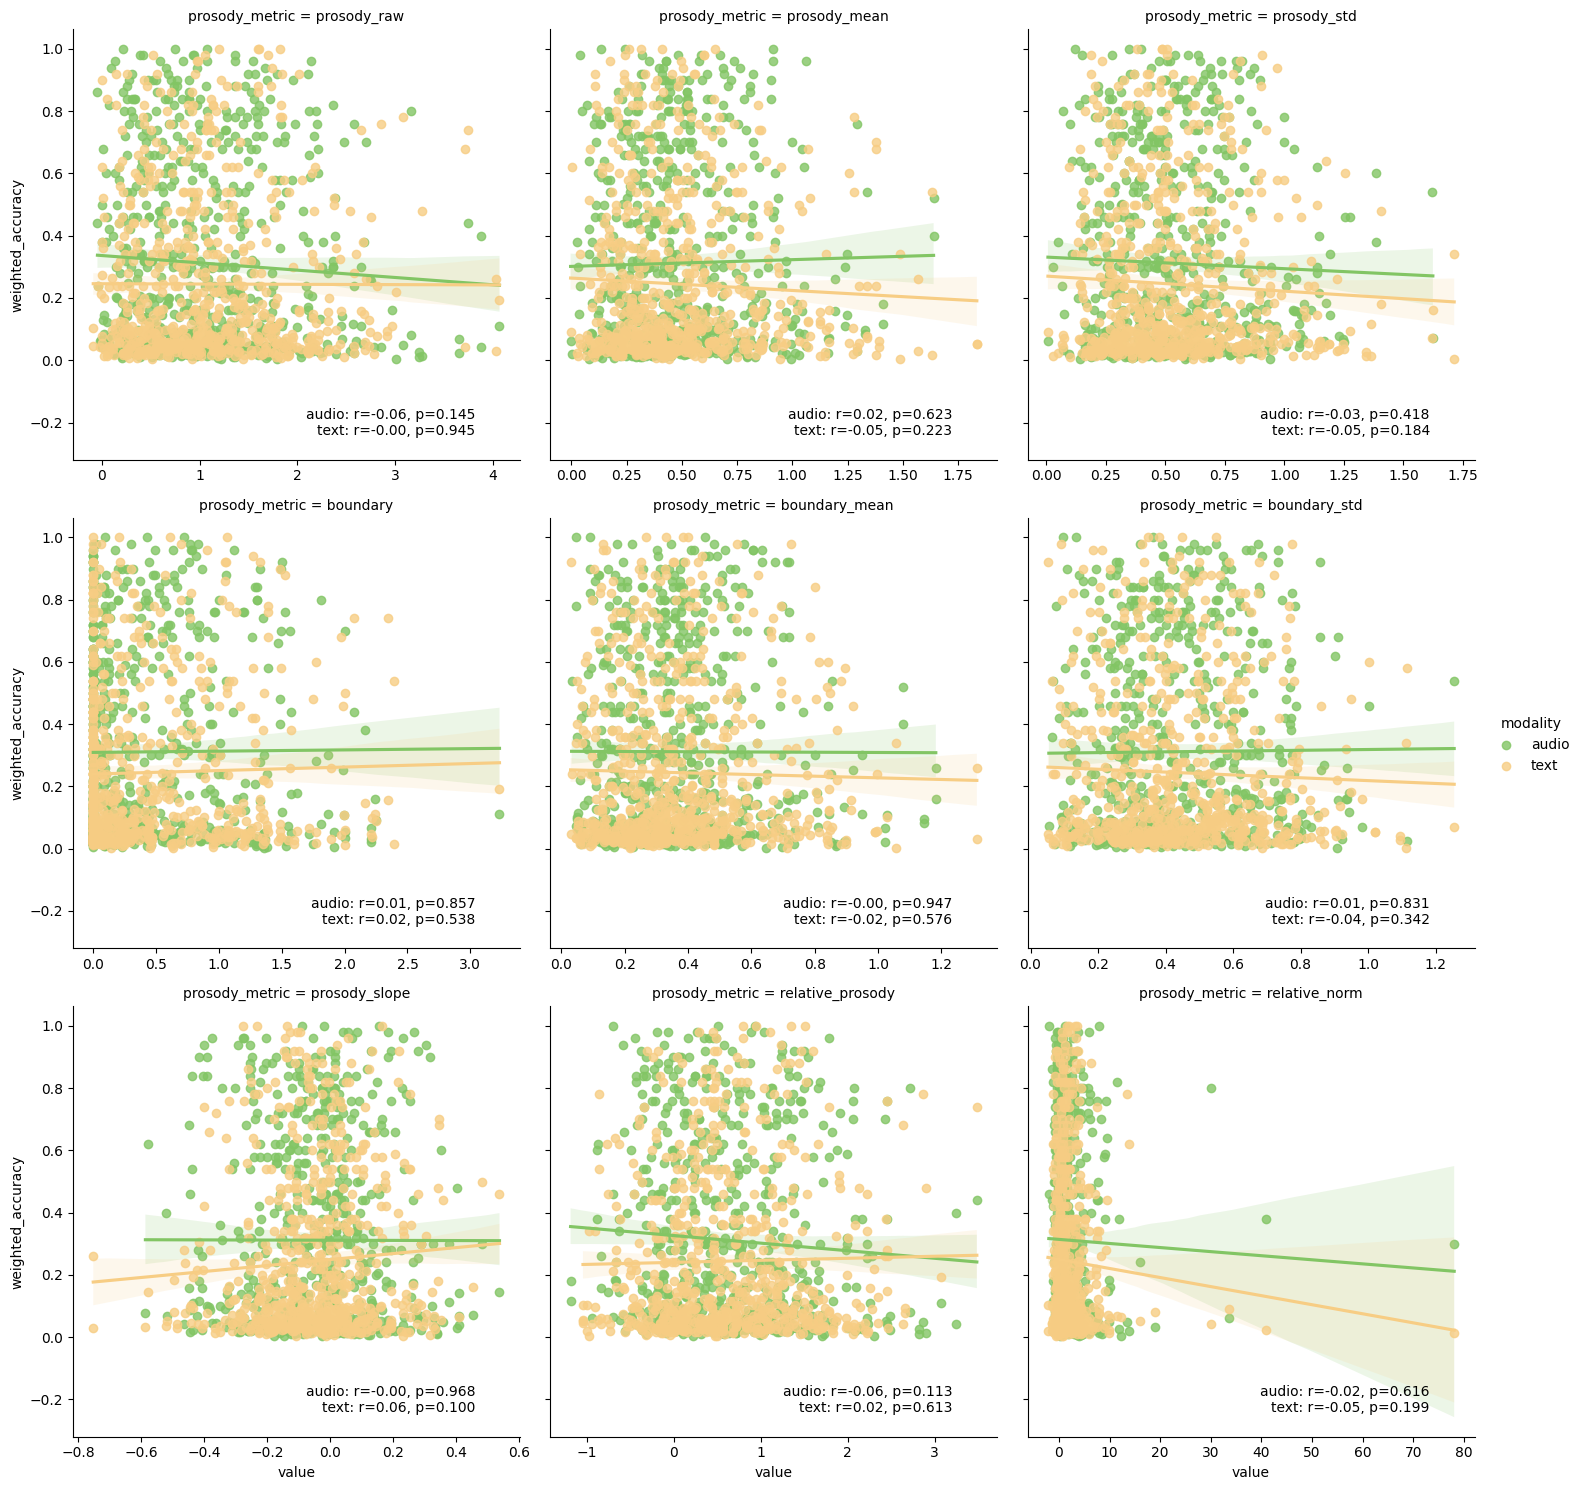

In [29]:
accuracy_variable = 'weighted_accuracy' #'fasttext_top_word_accuracy'

g = sns.lmplot(df_plot, 
           x='value', 
           y=accuracy_variable, 
           col='prosody_metric',
           hue='modality',
           sharex=False,
           col_wrap=3,
           height=5, palette=cmap)

for i, prosody_var in enumerate(prosody_vars):

    df = g.data[g.data['prosody_metric'] == prosody_var]
    ax = g.axes[i] 
    df = df.dropna()
    dfs = [d for _, d in df.groupby('modality')]
    rvals, pvals = zip(*[stats.pearsonr(df[accuracy_variable], df['value']) for df in dfs])
    
    ax.annotate(f'audio: r={rvals[0]:.2f}, p={pvals[0]:.3f}\ntext: r={rvals[1]:.2f}, p={pvals[1]:.3f}',
                       xy=(0.9, 0.05), xycoords=ax.transAxes,
                       ha='right', va='bottom', fontsize=10)
    
plt.show()

AttributeError: 'FacetGrid' object has no attribute 'title'

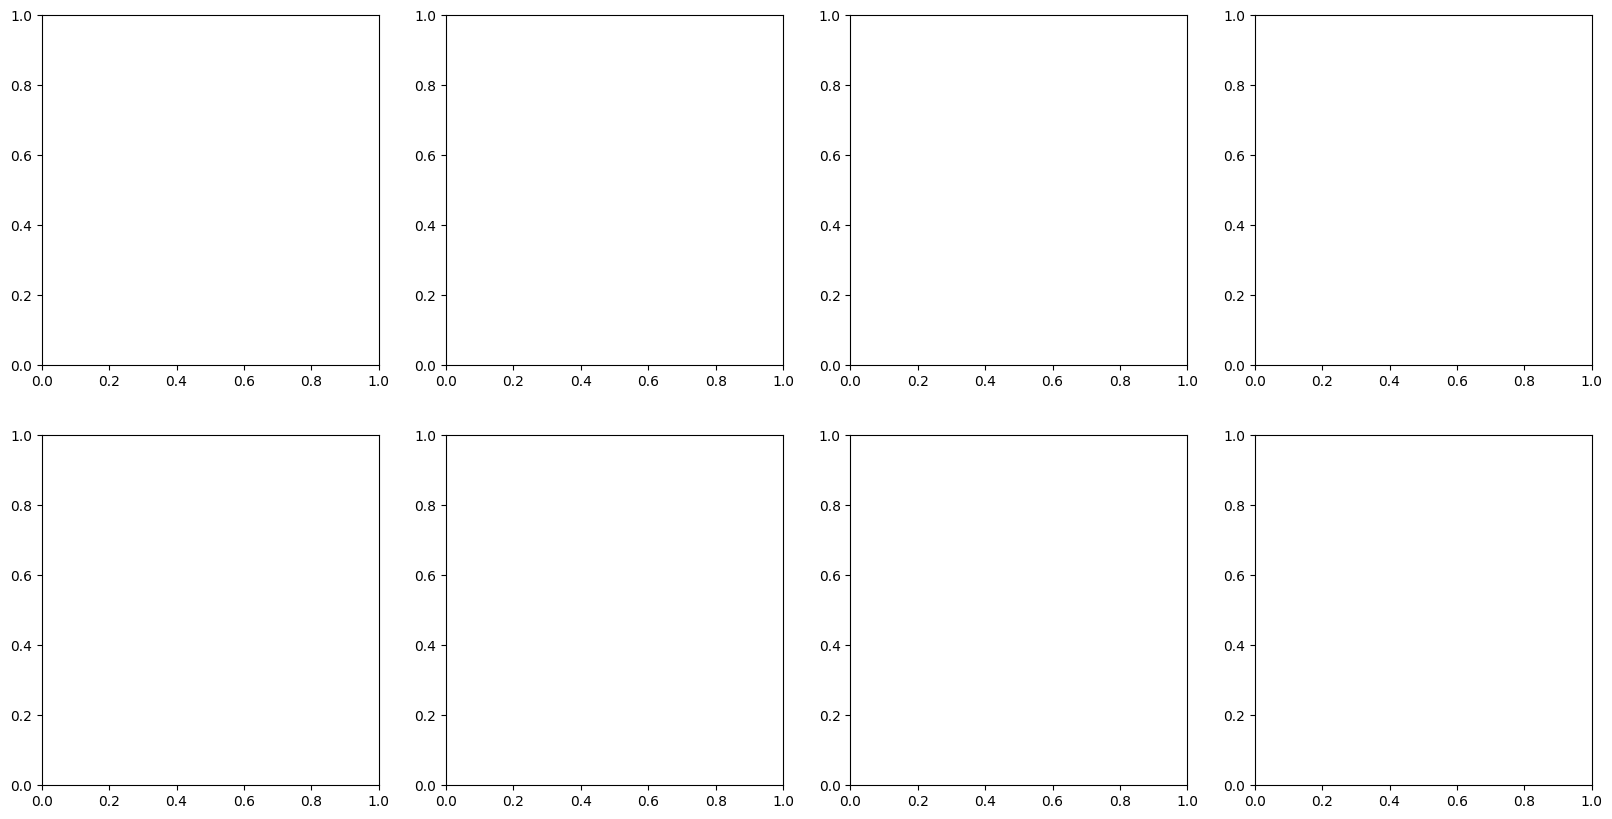

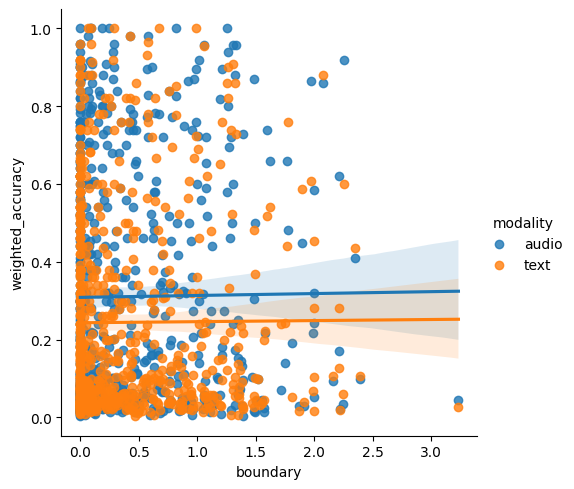

In [722]:

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, var in enumerate(prosody_vars):
    axes[i] = sns.lmplot(df_plot, x=var, y=accuracy_variable, hue='modality')
    axes[i].title.set_text(f'{accuracy_variable} ~ {var}')

                           sum_sq      df           F        PR(>F)
Intercept               16.239467     1.0  203.840965  3.845973e-43
modality                 0.248437     1.0    3.118427  7.764019e-02
prosody_mean             0.012140     1.0    0.152381  6.963330e-01
modality:prosody_mean    0.020676     1.0    0.259525  6.105311e-01
Residual               106.276229  1334.0         NaN           NaN


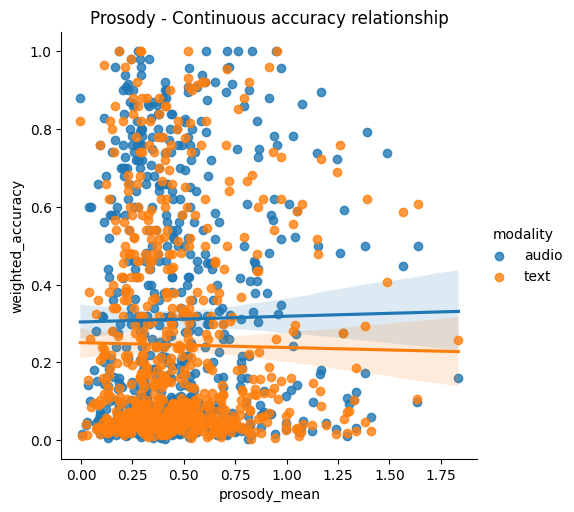

In [719]:
df_plot = df_results_stack.copy()

prosody_var = 'prosody_mean'
variable = 'weighted_accuracy'

# df_plot[prosody_var] = df_plot[prosody_var] ** 0.5

sns.lmplot(df_plot, x=prosody_var, y=variable, hue='modality') #, col='entropy_accuracy_group') #, col="entropy_accuracy_group")

plt.title('Prosody - Continuous accuracy relationship')
model = ols(f'{variable} ~ modality * {prosody_var}', data=df_plot).fit() #df_anova.dropna()).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print (anova_table)

## Try some fancier things

In [708]:
# get past five prosodic values

past_n_words = 5

prosody_values = []
accuracy_values = []

for task in task_list:
    
    df_selected = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-selected.csv'))
    df_prosody = pd.read_csv(os.path.join(prosody_dir, f'{task}.prom'), sep='\t', names=prosody_columns)
    df_human_results = pd.read_csv(os.path.join(results_dir, f'task-{task}_group-analyzed-behavior_human-lemmatized.csv'))

    df_human_results['weighted_accuracy'] = df_human_results['fasttext_top_word_accuracy'] * df_human_results['top_prob']

    df_prosody = calculate_prosody_metrics(df_prosody, n_prev=past_n_words, remove_characters=REMOVE_WORDS)

    pred_indices = np.where(df_selected['NWP_Candidate'])[0]
    pred_indices = pred_indices[pred_indices > past_n_words]

    values = np.stack([df_prosody['relative_prosody'].iloc[idx-past_n_words:idx].to_numpy() for idx in pred_indices])
    prosody_values.append(values)

    # now get accuracy values
    df_audio, df_text = [df[df['word_index'] > past_n_words] for i, df in df_human_results.groupby('modality')]
    accuracy_values.append(
        (df_audio['weighted_accuracy'].to_numpy(), df_text['weighted_accuracy'].to_numpy())
    )

prosody_values = np.concatenate(prosody_values)
acc_audio, acc_text = [np.concatenate(x) for x in zip(*accuracy_values)]

# remove anywhere with nan
remove = np.unique(np.argwhere(np.isnan(prosody_values))[:, 0])
prosody_values, acc_audio, acc_text = [np.delete(x, remove, axis=0) for x in [prosody_values, acc_audio, acc_text]]


### Build linear model

In [711]:
from sklearn.linear_model import LinearRegression

X = prosody_values
y = acc_audio
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.011039106392035092

In [703]:
X.shape

(642, 30)

Coefficients: 
 [-0.00522404  0.00378452 -0.01524833 -0.01179032 -0.00594019 -0.01265195
 -0.01233168 -0.01376952  0.00558877  0.00542256 -0.00504129  0.00704955
 -0.00053384  0.01646802 -0.0035744  -0.03474485  0.01506145  0.01128263
 -0.01669975 -0.00588063  0.01115997  0.01936202  0.0058951   0.00614707
 -0.0299754  -0.00678443 -0.01973175  0.00689629 -0.04805363 -0.02409124]
Mean squared error: 0.06
Coefficient of determination: 0.06


ValueError: x and y must be the same size

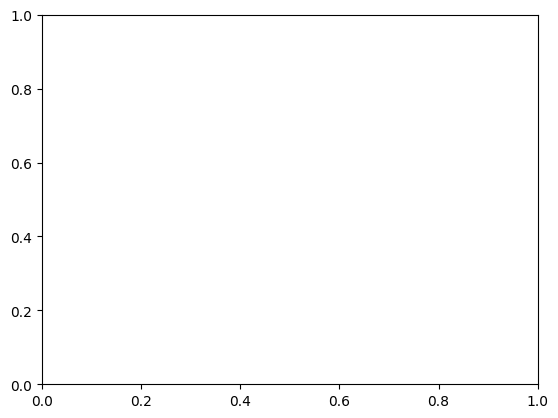

In [700]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions using the testing set
y_pred = reg.predict(X)

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X, y, color="black")
plt.plot(X, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [694]:
prosody_values

array([[ 0.0034, -0.5175,  1.913 , ...,  1.2372, -0.3231, -0.5331],
       [-0.3231, -0.5331, -0.2831, ...,  0.1305,  1.5831, -0.2012],
       [ 0.1441,  0.1305,  1.5831, ...,  0.6452,  0.3102, -0.7536],
       ...,
       [ 1.0416, -0.5353, -0.344 , ..., -0.0848,  0.9906, -0.3956],
       [-0.125 , -0.0848,  0.9906, ...,  0.914 , -0.3984, -0.3234],
       [-0.1421,  0.914 , -0.3984, ...,  0.2887, -0.3428, -0.1708]])

In [698]:
np.corrcoef(np.sum(prosody_values, axis=1), acc_audio)

array([[ 1.        , -0.13509231],
       [-0.13509231,  1.        ]])